In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

In [2]:
plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.facecolor"] = "white"

In [3]:
neurons = sc.read("../data/h5ad/neuronal-final.h5ad")

/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support,
    accuracy_score, confusion_matrix
)

In [5]:
from itertools import chain
def feature_selection(adata, inds, groupby="cluster_revised", n_top_genes=10):
    tmp = adata[inds,].copy()
    sc.tl.rank_genes_groups(
        tmp, method="wilcoxon", groupby=groupby,use_raw=False, 
        n_genes=n_top_genes, key_added="feature_selection"
    )
    return list(set(chain.from_iterable(tmp.uns["feature_selection"]["names"])))

In [6]:
def train_test(adata, label_key, n_top_genes=10, test_frac=0.3, verbose=False, exclude=None):
    included = adata
    if exclude is not None:
        exclude_inds = adata.obs[label_key].isin(exclude)
        included = adata[~exclude_inds, :]
    labels = included.obs[label_key].values.astype(int)
    inds_train, inds_test, y_train, y_test = train_test_split(
        np.arange(included.shape[0]), labels, 
        test_size=test_frac, stratify=labels,
        shuffle=True, random_state=0,
    )
    genes_train = feature_selection(neurons, inds_train, label_key, n_top_genes=n_top_genes)
    X_train = included[inds_train, :][:, genes_train].X
    X_test = included[inds_test, :][:, genes_train].X
    print(X_train.shape, X_test.shape)
    
    forest = RandomForestClassifier(class_weight="balanced", random_state=0, verbose=verbose)
    forest.fit(X_train, y_train)
    pred = forest.predict(X_test)
    return y_test, pred

In [7]:
results = {}
for k in [2, 3, 5, 10, 15, 20]:
    results[k] = train_test(neurons, "cluster_revised", n_top_genes=k, test_frac=0.3)

(6512, 34) (2792, 34)
(6512, 49) (2792, 49)
(6512, 80) (2792, 80)
(6512, 143) (2792, 143)
(6512, 216) (2792, 216)
(6512, 278) (2792, 278)


In [8]:
results_ex = {}
for k in [2, 3, 5, 10, 15, 20]:
    results_ex[k] = train_test(neurons, "cluster_revised", n_top_genes=k, test_frac=0.3, exclude=["9","10","11","12","13"])

(5226, 35) (2240, 35)
(5226, 50) (2240, 50)
(5226, 76) (2240, 76)
(5226, 146) (2240, 146)
(5226, 217) (2240, 217)
(5226, 280) (2240, 280)


In [8]:
labels = sum((
    [f"GLUT{k}" for k in range(1, 12)],
    [f"GABA{k}" for k in range(12, 16)],
    ["GLUT16", "HA17", "GABA18", "GABA19", "GLUT20"]), []
)

In [9]:
regions = sum([
    ["MB"]*5, ["PM"]*2, ["SUM"], ["Unknown"]*5,
    ["ARC", "LHA", "ARC", "TMN", "ARC", "LHA", "LM"]
], []
)

In [12]:
from plotting.palettes import neuronal_palette
from plotting.plot_funcs import save_figure
import seaborn as sns

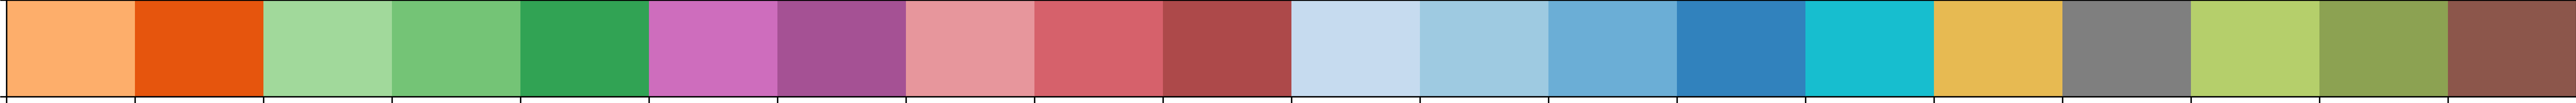

In [13]:
sns.palplot(neuronal_palette)

In [14]:
region_palette = [
    neuronal_palette[1], neuronal_palette[5], neuronal_palette[7], neuronal_palette[13], 
    neuronal_palette[-5], neuronal_palette[-2], neuronal_palette[-4], neuronal_palette[-1]
]

In [15]:
dfs = []
for k in results:
    df = pd.DataFrame(
        np.column_stack(precision_recall_fscore_support(*results[k])), 
        columns=["precision", "recall", "fscore", "support"], 
    )
    df["cluster"] = labels
    df["region"] = regions
    df["k"] = k
    dfs.append(df)
prfs = pd.concat(dfs)

Saved to sensitivity_per_cluster.pdf


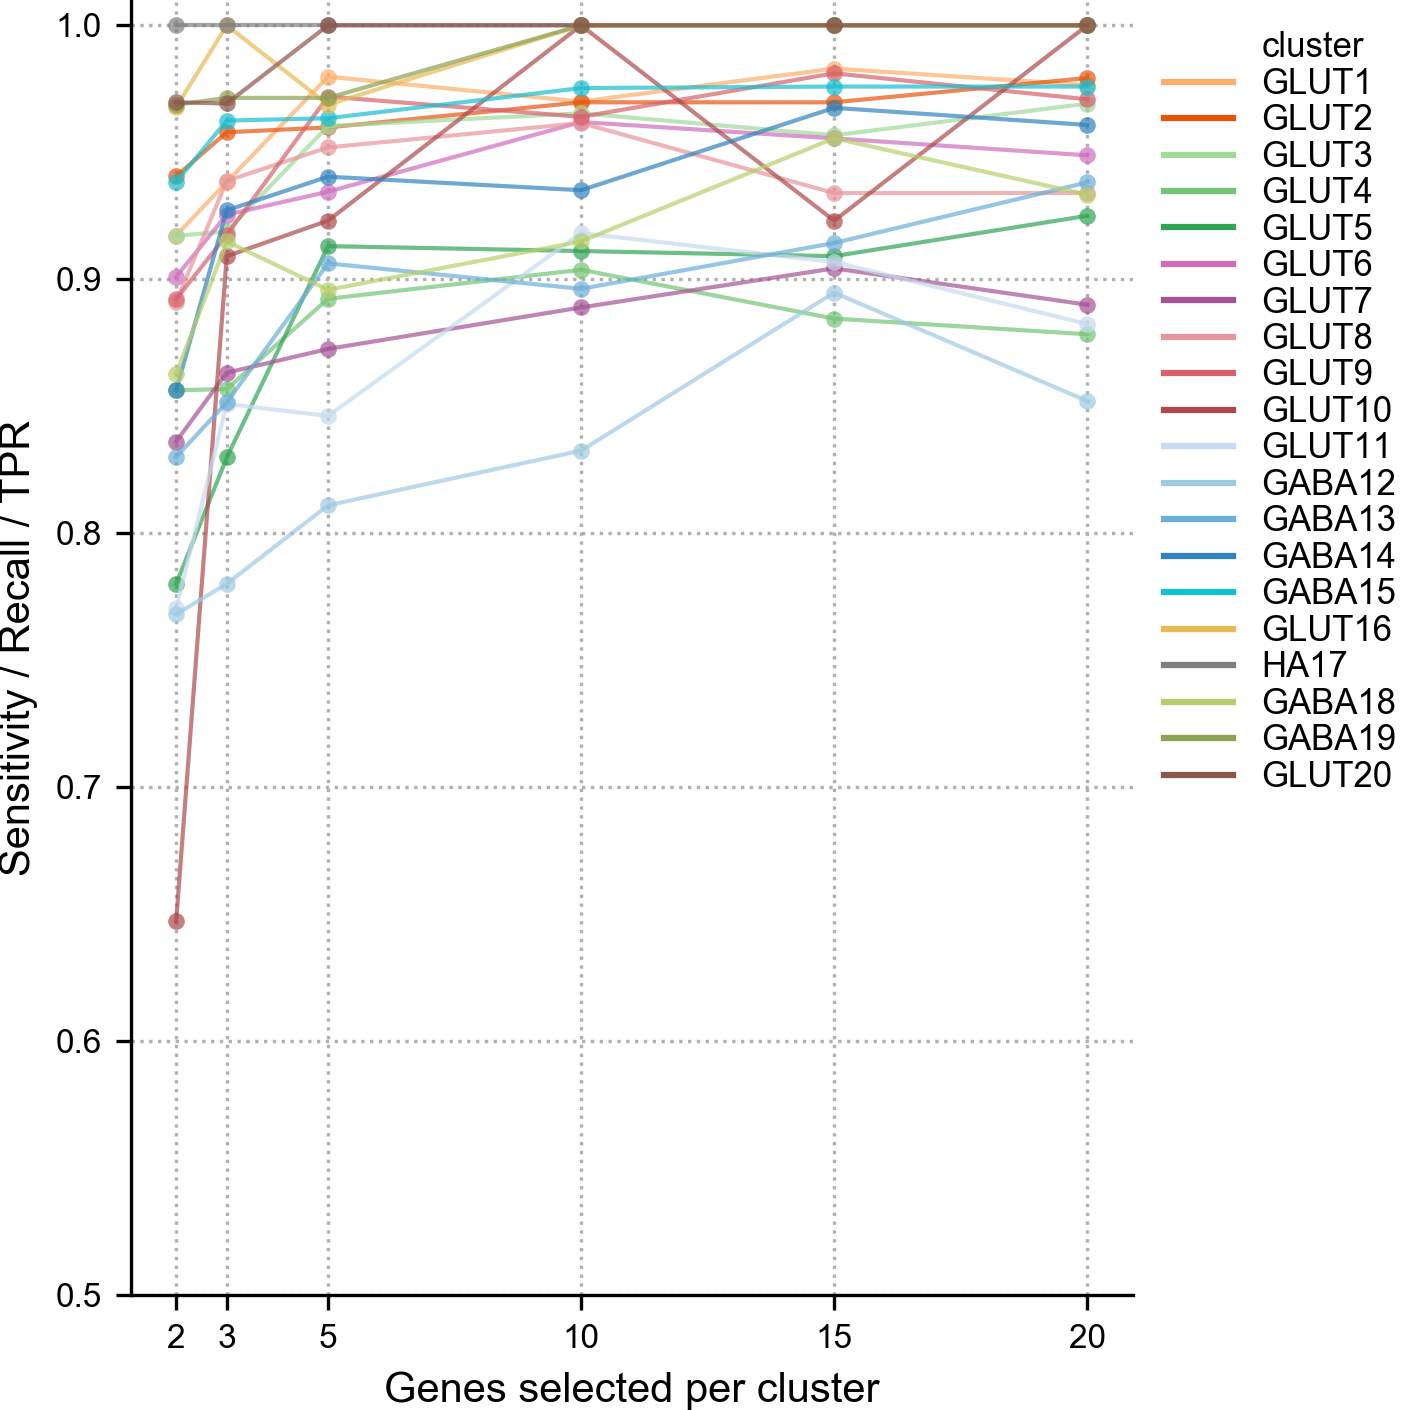

In [42]:
fig, ax = plt.subplots(dpi=300, figsize=(5,5))
seaborn.lineplot(
    data=prfs, x="k", y="precision", hue="cluster", 
    err_style="band", ci=68, alpha=0.7,
    lw=1, marker="o", markeredgecolor="none", markersize=4, 
    ax=ax, palette=neuronal_palette
)
ax.set_ylim(0.5, 1.01)
ax.legend(bbox_to_anchor=(1,1), loc="upper left", frameon=False, 
          fancybox=False, edgecolor="k", fontsize="small", labelspacing=0.1)
ax.set_xlabel("Genes selected per cluster")
ax.set_ylabel("Sensitivity / Recall / TPR")
ax.set_xticks([2, 3, 5, 10, 15, 20])
seaborn.despine(fig, ax)
ax.grid(True, ls=":")
fig.tight_layout()
save_figure(fig, "classifier", "sensitivity_per_cluster")

Saved to sensitivity_per_region.pdf


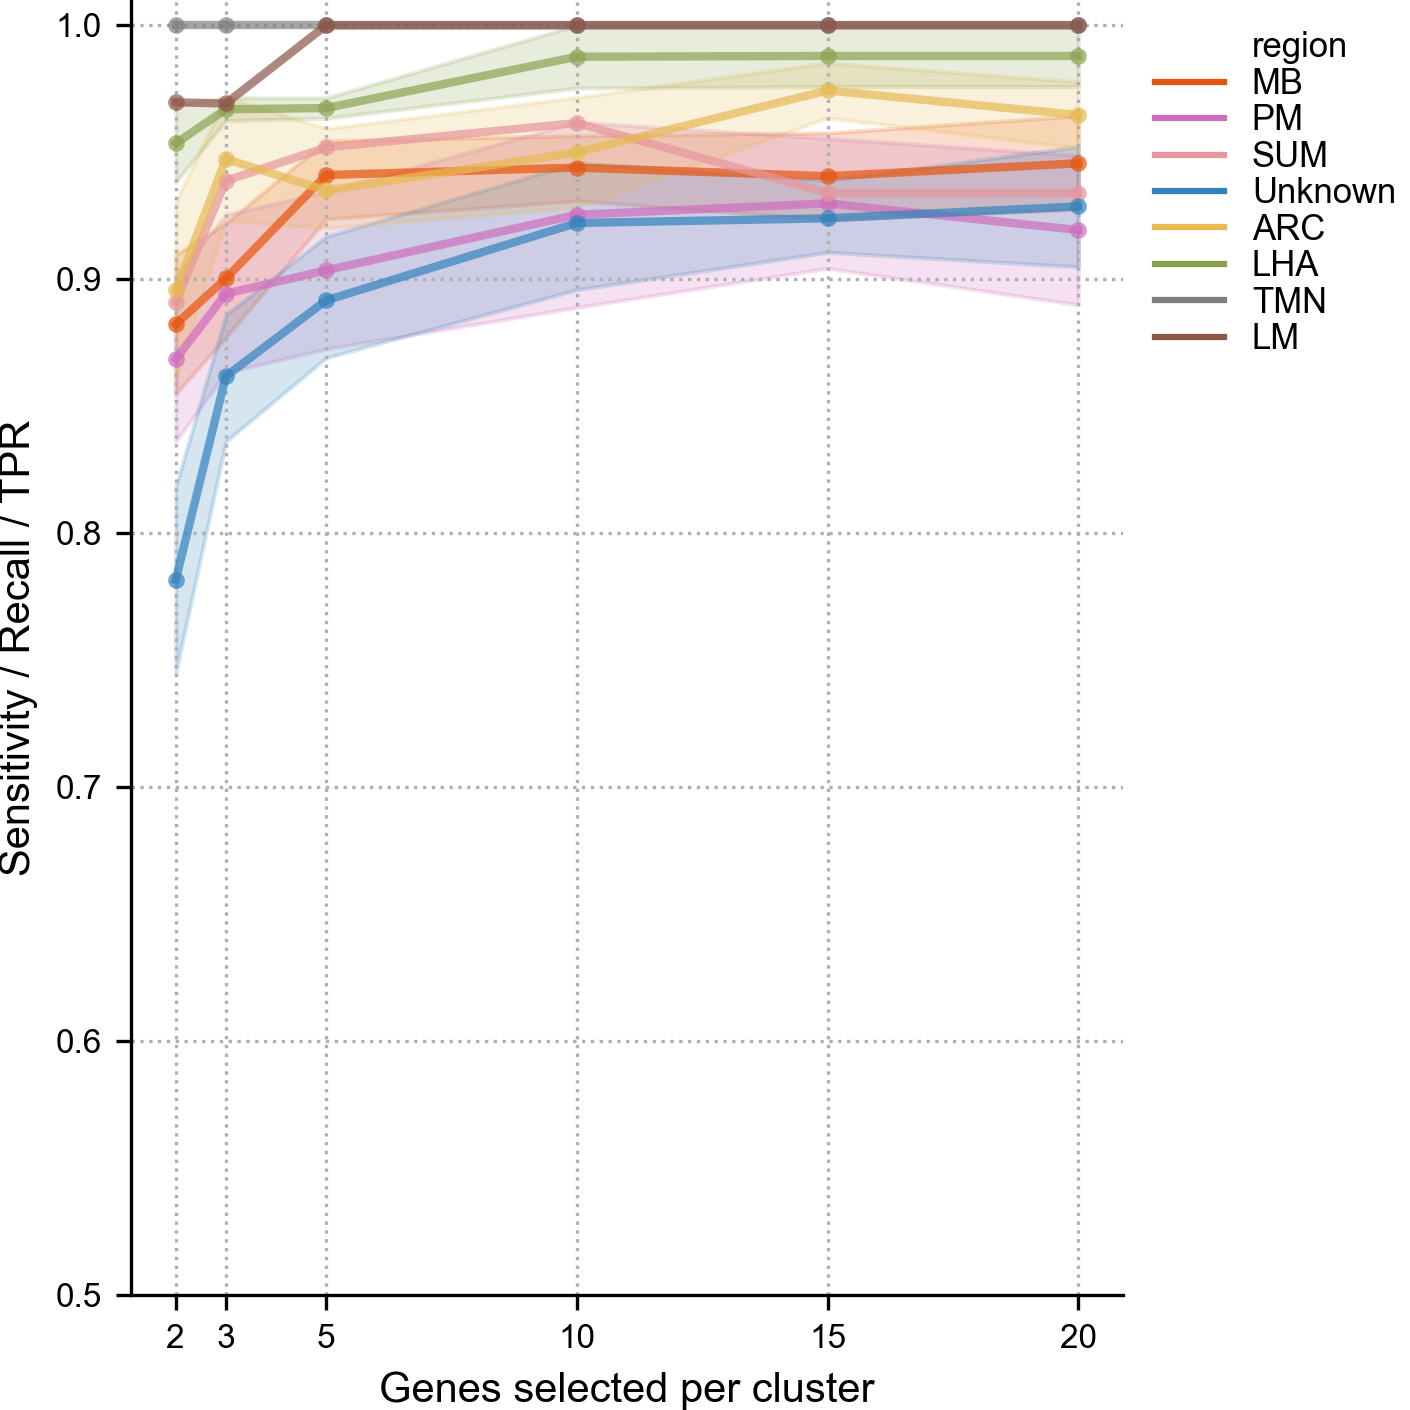

In [43]:
fig, ax = plt.subplots(dpi=300, figsize=(5,5))
seaborn.lineplot(
    data=prfs, x="k", y="precision", hue="region", 
    err_style="band", ci=68, alpha=0.7,
    lw=2, marker="o", markeredgecolor="none", markersize=4, 
    ax=ax, palette=region_palette
)
ax.set_ylim(0.5, 1.01)
ax.legend(bbox_to_anchor=(1,1), loc="upper left", frameon=False, 
          fancybox=False, edgecolor="k", fontsize="small", labelspacing=0.1)
ax.set_xlabel("Genes selected per cluster")
ax.set_ylabel("Sensitivity / Recall / TPR")
ax.set_xticks([2, 3, 5, 10, 15, 20])
seaborn.despine(fig, ax)
ax.grid(True, ls=":")
fig.tight_layout()
save_figure(fig, "classifier", "sensitivity_per_region")

Saved to global_accuracy.pdf


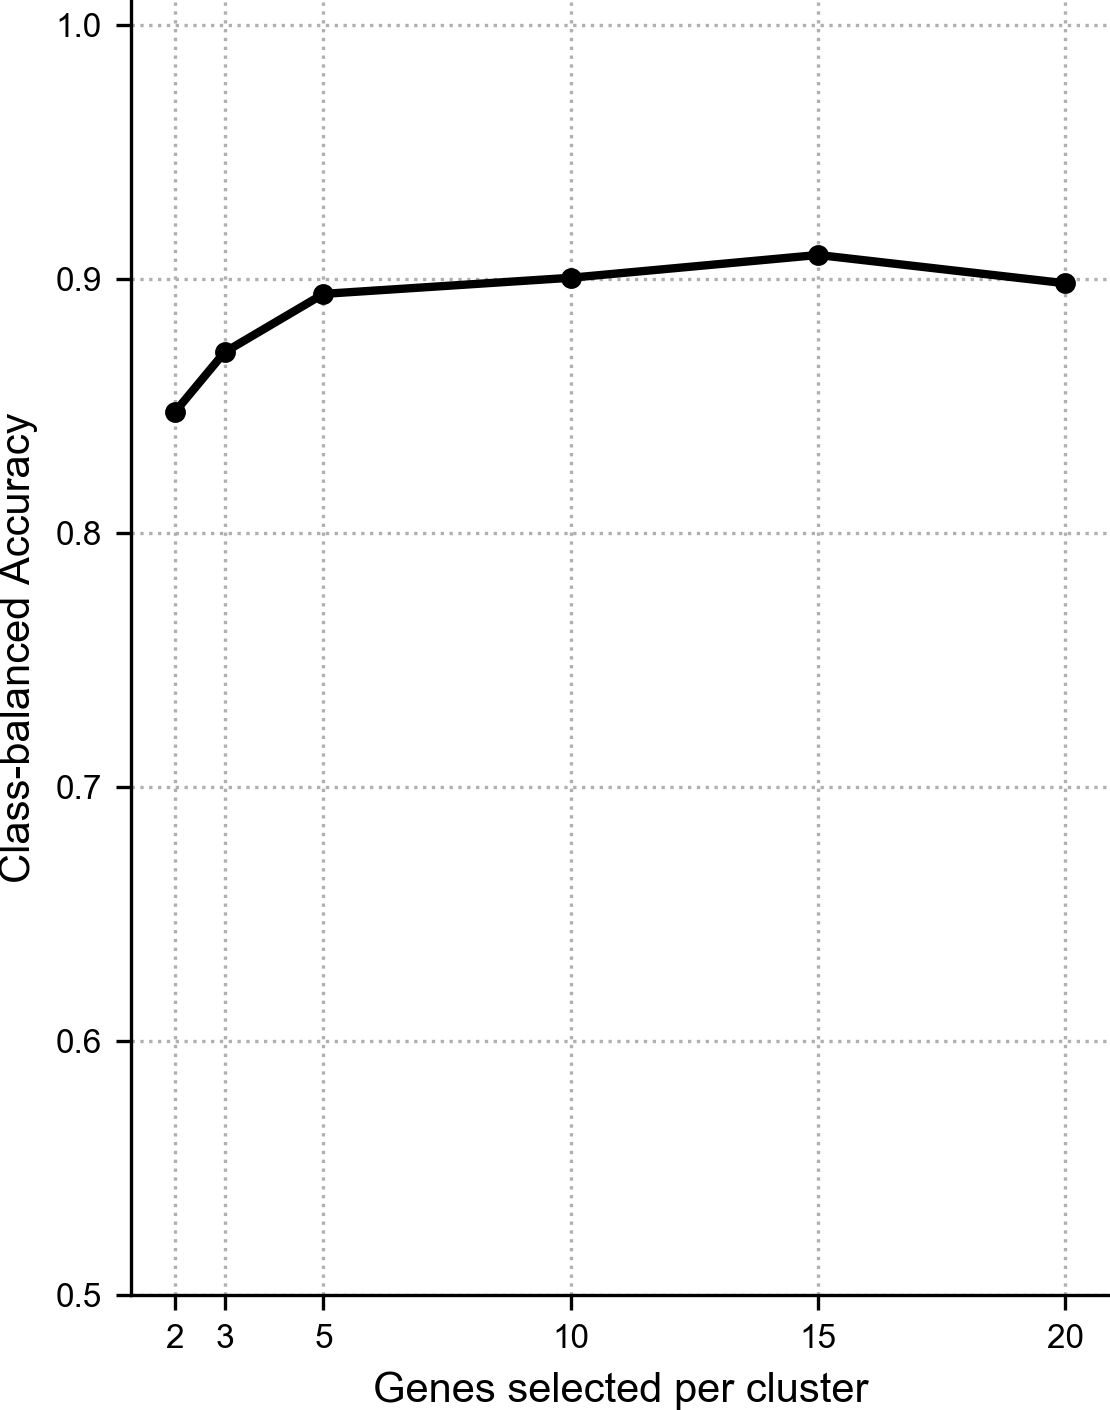

In [45]:
x1, y1 = zip(*[(k, balanced_accuracy_score(*results[k])) for k in results])
#x2, y2 = zip(*[(k, balanced_accuracy_score(*results_ex[k])) for k in results])
fig, ax = plt.subplots(dpi=300, figsize=(4,5))
#seaborn.lineplot(x=x1, y=y1, ax=ax)
ax.plot(x1, y1, "k-o", label="All cluster", lw=2, ms=4)
#ax.plot(x2, y2, "r-o", label="Excluding 9-13")
ax.set_ylim(0.5, 1.01)
ax.set_xlabel("Genes selected per cluster")
ax.set_ylabel("Class-balanced Accuracy")
ax.grid(True, ls=":")
ax.set_xticks([2, 3, 5, 10, 15, 20])
seaborn.despine(fig, ax)
fig.tight_layout()
#ax.legend(loc="lower right", frameon=True, fancybox=False, edgecolor="k")
save_figure(fig, "classifier", "global_accuracy")

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

Saved to confusion_matrix.pdf


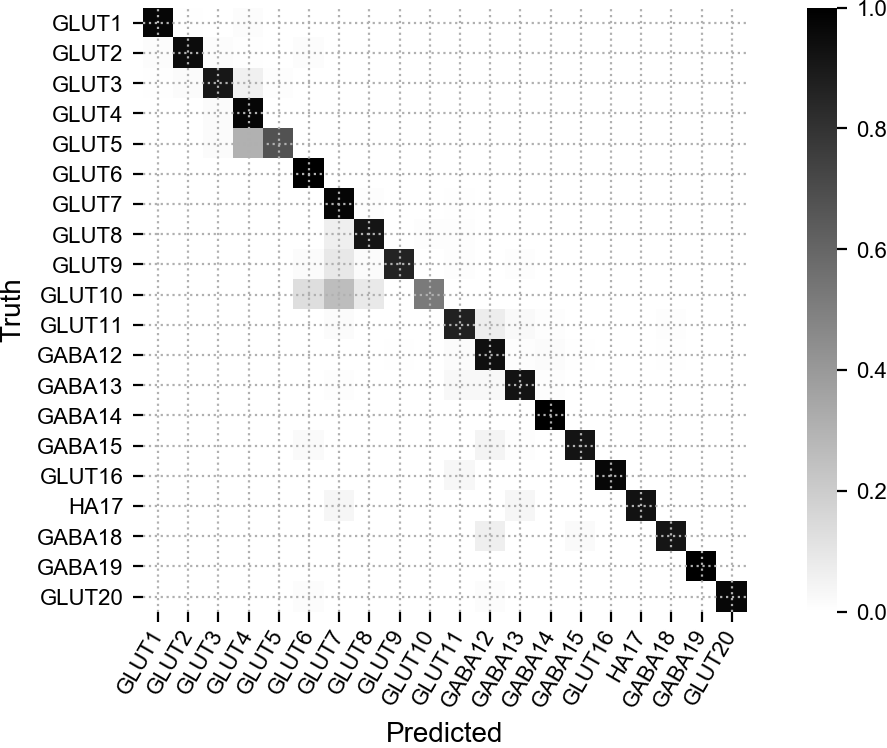

In [35]:
fig, ax = plt.subplots(dpi=200)
cmat = confusion_matrix(*results[15])
cmat = cmat/cmat.sum(axis=1)[:, None]
sns.heatmap(cmat, cmap="binary", norm=Normalize(), square=True, xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("Truth")
ax.grid(ls=":")
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right", va="center", rotation_mode="anchor");
save_figure(fig, "classifier", "confusion_matrix")

Saved to cells_per_cluster.pdf


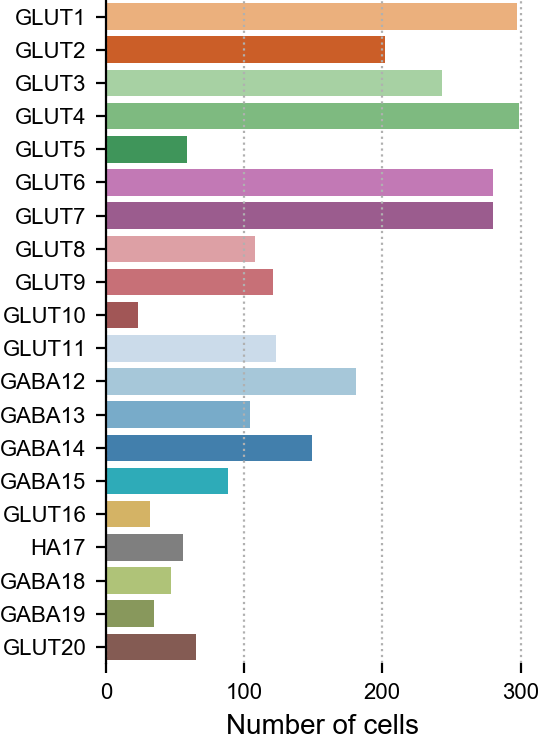

In [46]:
fig, ax = plt.subplots(dpi=200, figsize=(3, 4))
sns.barplot(data=prfs[prfs.k==10], y="cluster", x="support", ax=ax, palette=neuronal_palette)
ax.set_xlabel("Number of cells")
ax.grid(ls=":", axis="x")
sns.despine(fig, ax, bottom=True)
ax.set_ylabel("")
fig.tight_layout()
save_figure(fig, "classifier", "cells_per_cluster")